Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Processed 22/200 texts.
Layer 0: Intrinsic Dimension = 292
Layer 1: Intrinsic Dimension = 231
Layer 2: Intrinsic Dimension = 144
Layer 3: Intrinsic Dimension = 1
Layer 4: Intrinsic Dimension = 1
Layer 5: Intrinsic Dimension = 1
Layer 6: Intrinsic Dimension = 1
Layer 7: Intrinsic Dimension = 4
Layer 8: Intrinsic Dimension = 20
Layer 9: Intrinsic Dimension = 54
Layer 10: Intrinsic Dimension = 104
Layer 11: Intrinsic Dimension = 155
Layer 12: Intrinsic Dimension = 3


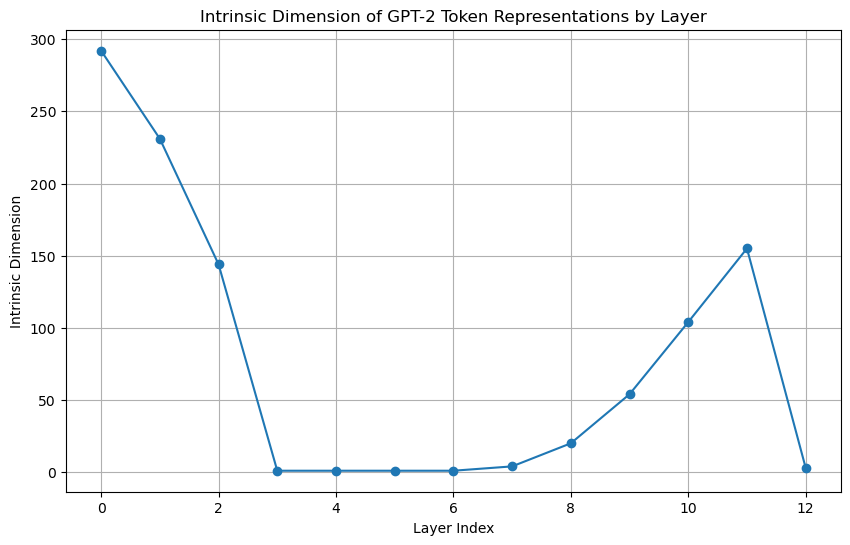

In [2]:
import torch
from transformers import GPT2Model, GPT2Tokenizer
from datasets import load_dataset
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def perform_pca_and_eigenvalue_analysis(model_name, texts, variance_threshold=0.9, batch_size=10):
    """
    Perform PCA on the token representations of each GPT-2 module and determine
    the number of components required to explain a given percentage of variance.

    Args:
    - model_name (str): Name of the pre-trained GPT-2 model from the transformers library.
    - texts (list of str): List of input texts to feed into the GPT-2 model.
    - variance_threshold (float): The cumulative variance threshold (default is 0.9 for 90%).
    - batch_size (int): Number of texts to process in each batch.

    Returns:
    - intrinsic_dimensions (dict): Dictionary with layer indices as keys and intrinsic dimensions as values.
    """

    # Load pre-trained GPT-2 model and tokenizer
    model = GPT2Model.from_pretrained(model_name)
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)

    # Set model to evaluation mode
    model.eval()

    all_hidden_states_by_layer = None

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_hidden_states_by_layer = []

        for text in batch_texts:
            # Tokenize input text
            inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)

            # Get hidden states from the GPT-2 model
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)
                hidden_states = outputs.hidden_states  # A tuple with layers of hidden states

            # Accumulate hidden states for this batch
            batch_hidden_states_by_layer.append(hidden_states)

        # Concatenate hidden states for all texts in the batch
        if all_hidden_states_by_layer is None:
            all_hidden_states_by_layer = [layer.squeeze().cpu().numpy() for layer in batch_hidden_states_by_layer[0]]
            for layer in batch_hidden_states_by_layer[1:]:
                for i, hidden_state in enumerate(layer):
                    all_hidden_states_by_layer[i] = np.concatenate((all_hidden_states_by_layer[i], hidden_state.squeeze().cpu().numpy()), axis=0)
        else:
            for layer in batch_hidden_states_by_layer:
                for i, hidden_state in enumerate(layer):
                    all_hidden_states_by_layer[i] = np.concatenate((all_hidden_states_by_layer[i], hidden_state.squeeze().cpu().numpy()), axis=0)

        print(f"Processed {i + len(batch_texts)}/{len(texts)} texts.")

    intrinsic_dimensions = {}

    for layer_index, hidden_state in enumerate(all_hidden_states_by_layer):
        # Perform PCA
        pca = PCA()
        pca.fit(hidden_state)

        # Calculate cumulative explained variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

        # Determine the number of components needed to reach the variance threshold
        intrinsic_dimension = np.argmax(cumulative_variance >= variance_threshold) + 1
        intrinsic_dimensions[layer_index] = intrinsic_dimension

        print(f"Layer {layer_index}: Intrinsic Dimension = {intrinsic_dimension}")

    return intrinsic_dimensions

# Load the IMDb dataset from the Hugging Face datasets library
dataset = load_dataset('imdb', split='train')

# Convert the dataset to a list of strings
texts = dataset['text'][:200]  # Use the first 200 samples for demonstration

# Perform PCA and eigenvalue analysis
model_name = 'gpt2'
variance_threshold = 0.9
batch_size = 10
intrinsic_dimensions = perform_pca_and_eigenvalue_analysis(model_name, texts, variance_threshold=variance_threshold, batch_size=batch_size)

# Plot the intrinsic dimensions for each layer
plt.figure(figsize=(10, 6))
plt.plot(list(intrinsic_dimensions.keys()), list(intrinsic_dimensions.values()), marker='o')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.title('Intrinsic Dimension of GPT-2 Token Representations by Layer')
plt.grid(True)
plt.show()
